# basic model

In [83]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
import yfinance as yf

In [84]:
df = pd.read_csv('df_2012.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

In [85]:
df.columns

Index(['Adj Close gold', 'Adj Close RING', 'Adj Close Brent',
       'Adj Close Silver', 'Adj Close Palladium', 'Adj Close Freight',
       'Adj Close CA', 'Adj Close TNX', 'Adj Close VIX', 'Adj Close PLAT',
       'Adj Close Copper', 'Adj Close SPX', 'Adj Close NDQ',
       'Adj Close EUR/USD', 'Adj Close USD/JPY', 'Adj Close USD/CHF'],
      dtype='object')

In [86]:
feature_columns = ['Adj Close gold', 'Adj Close RING', 'Adj Close Brent',
       'Adj Close Silver', 'Adj Close Palladium', 'Adj Close Freight',
       'Adj Close CA', 'Adj Close TNX', 'Adj Close VIX', 'Adj Close PLAT',
       'Adj Close Copper', 'Adj Close SPX', 'Adj Close NDQ',
       'Adj Close EUR/USD', 'Adj Close USD/JPY', 'Adj Close USD/CHF']

In [87]:
#preprocessing / scaling the data of the train set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data_train = scaler.fit_transform(df[feature_columns][:-280])
feature_minmax_transform_train = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data_train, index=df[:-280].index)
feature_minmax_transform_train

,Adj Close gold,Adj Close RING,Adj Close Brent,Adj Close Silver,Adj Close Palladium,Adj Close Freight,Adj Close CA,Adj Close TNX,Adj Close VIX,Adj Close PLAT,Adj Close Copper,Adj Close SPX,Adj Close NDQ,Adj Close EUR/USD,Adj Close USD/JPY,Adj Close USD/CHF
Date,,,,,,,,,,,,,,,,
2012-02-03,0.686619,0.958316,0.914349,0.865578,0.094832,0.714066,0.127970,0.530165,0.108226,0.906014,0.689503,0.019002,0.011884,0.775810,0.000000,0.357793
2012-02-06,0.671530,0.952985,0.908072,0.865460,0.093679,0.714566,0.126319,0.512614,0.117199,0.904173,0.676118,0.018840,0.011609,0.772985,0.007503,0.368032
2012-02-07,0.695113,0.962679,0.918197,0.882897,0.094951,0.710063,0.121812,0.536380,0.115704,0.926091,0.680874,0.019613,0.011766,0.771428,0.007483,0.369738
2012-02-08,0.678025,0.951046,0.920221,0.863531,0.097635,0.715067,0.122628,0.539671,0.122638,0.937752,0.692673,0.020440,0.012651,0.807273,0.012336,0.328954
2012-02-09,0.687719,0.952985,0.927848,0.871836,0.095806,0.713065,0.120436,0.565996,0.129028,0.937314,0.716802,0.021006,0.013505,0.807273,0.017796,0.335040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.743679,0.430083,0.848947,0.419602,0.747088,0.122349,0.936414,0.469104,0.213324,0.371120,0.837795,0.920134,0.863444,0.215202,0.790350,0.436462
2022-02-01,0.748976,0.437914,0.849285,0.427514,0.744703,0.131767,0.957438,0.475686,0.174303,0.373400,0.876893,0.928942,0.871417,0.237028,0.787498,0.413424
2022-02-02,0.757869,0.441425,0.849690,0.432041,0.753846,0.138394,0.961471,0.463254,0.176071,0.391373,0.898732,0.941117,0.876792,0.249543,0.779712,0.378498


In [88]:
#shifting the gold close by a day so that we try and predict
target_train = feature_minmax_transform_train['Adj Close gold'].shift(-1)

In [89]:
#cutting the target for the train
y_train = target_train[:-1]

In [90]:
#cutting the train set
X_train = feature_minmax_transform_train[:-1]

In [91]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [92]:
params = {
    #'eval_metric': 'rmse',
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [25, 50, 100, 200, 300, 400, 500]
}

cv = TimeSeriesSplit(n_splits=3)

model = XGBRegressor()
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=50, n_jobs=-1, cv=cv, verbose=3)

In [93]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [25, 50, 100, 200, 300,
                                                         400, 500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   verbose=3)

In [94]:
#apply the same scalar to the test set so there's no data leakage
feature_minmax_transform_test = scaler.transform(df[feature_columns][-281:])
feature_minmax_transform_test = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_test, index=df[-281:].index)
feature_minmax_transform_test

,Adj Close gold,Adj Close RING,Adj Close Brent,Adj Close Silver,Adj Close Palladium,Adj Close Freight,Adj Close CA,Adj Close TNX,Adj Close VIX,Adj Close PLAT,Adj Close Copper,Adj Close SPX,Adj Close NDQ,Adj Close EUR/USD,Adj Close USD/JPY,Adj Close USD/CHF
Date,,,,,,,,,,,,,,,,
2022-02-04,0.755271,0.431163,0.877025,0.422751,0.722520,0.140836,0.952884,0.523218,0.191434,0.374277,0.896090,0.915865,0.852785,0.295245,0.784182,0.375256
2022-02-07,0.769261,0.448446,0.870343,0.446408,0.710356,0.148859,0.949431,0.518099,0.186540,0.370857,0.888341,0.911130,0.846598,0.300721,0.789581,0.402275
2022-02-08,0.775257,0.457358,0.857114,0.451092,0.711986,0.154440,0.962875,0.531993,0.167233,0.385148,0.887636,0.921836,0.860030,0.297278,0.786325,0.390501
2022-02-09,0.783851,0.460598,0.859139,0.456642,0.720215,0.161765,0.984412,0.522852,0.147111,0.385850,0.937302,0.940492,0.882263,0.291150,0.795790,0.401593
2022-02-10,0.784851,0.438724,0.860624,0.463846,0.712344,0.166997,0.977533,0.560146,0.200816,0.390321,0.957379,0.916874,0.859368,0.291224,0.797225,0.397156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,0.765664,0.327278,0.764781,0.351702,0.373922,0.185996,0.856888,1.251554,0.160571,0.303086,0.728954,0.768562,0.655111,0.046403,1.217719,0.487088
2023-02-28,0.777556,0.335004,0.774028,0.363157,0.371497,0.192588,0.853197,1.249360,0.157172,0.315010,0.760127,0.765126,0.654251,0.062346,1.216142,0.461888
2023-03-01,0.786349,0.345214,0.778348,0.363078,0.378374,0.192808,0.856860,1.277879,0.155540,0.320533,0.784960,0.759794,0.648537,0.052772,1.216769,0.497543


In [95]:
#shifting the gold close by a day so that we try and predict
target_test = feature_minmax_transform_test['Adj Close gold'].shift(-1)

In [96]:
#cutting to leave the target test set
y_test = target_test[-281:-1]

In [97]:
#cutting to just leave the test set
X_test = feature_minmax_transform_test[-281:-1]

In [98]:
def validate_result(model, model_name):
    predicted = model.predict(X_test)
    RSME_score = np.sqrt(mean_squared_error(y_test, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(y_test, predicted)
    print('R2 score: ', R2_score)

    plt.plot(y_test.index, predicted,'r', label='Predict')
    plt.plot(y_test.index, y_test,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

In [99]:
# Print the best hyperparameters
print(random_search.best_params_)

# Make predictions on the test set using the best model
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print('RMSE:', rmse)
print('R2 score:', r2)

{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.15, 'colsample_bytree': 1.0}
RMSE: 0.05425338283411473
R2 score: 0.6659449666163507


In [100]:
best_xgb_fit = best_xgb.fit(X_train, y_train)

RMSE:  0.05425338283411473
R2 score:  0.6659449666163507


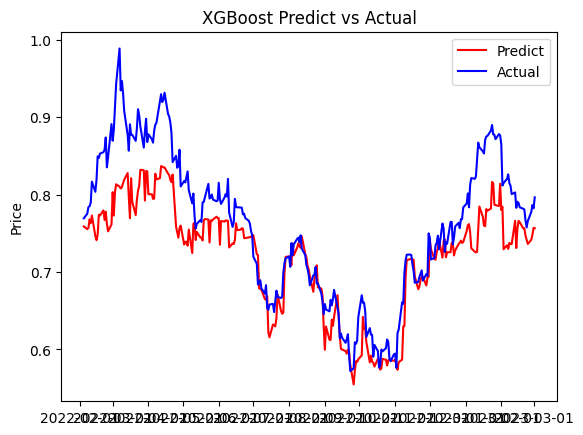

In [101]:
validate_result(best_xgb_fit,'XGBoost')

In [102]:
best_xgb_fit_list = best_xgb_fit.predict(X_test)

In [103]:
best_xgb_fit_list = best_xgb_fit_list.tolist()

In [104]:
max_gold = feature_minmax_transform_train['Adj Close gold'].max()
min_gold = feature_minmax_transform_train['Adj Close gold'].min()

In [105]:
predict_real = []
for i in best_xgb_fit_list:
    predict_real.append((((max_gold - min_gold)*i)+min_gold))

In [106]:
best_xgb_fit_list = pd.DataFrame(predict_real,columns=['predict'])

In [107]:
actual = []
for i in y_test:
    actual.append(i)

In [108]:
actual_real = []
for i in actual:
    actual_real.append((((max_gold - min_gold)*i)+min_gold))

In [109]:
best_xgb_fit_list['actual'] = actual_real

In [110]:
best_xgb_fit_list['actual_1'] = best_xgb_fit_list['actual'].shift(1)

In [111]:
best_xgb_fit_list['pred_change'] = best_xgb_fit_list['predict'] - best_xgb_fit_list['actual_1']

In [112]:
#create a signal column for the prediction
signal = []
for index, row in best_xgb_fit_list.iterrows():
    if row['pred_change'] > 0:
        signal.append(1)
    else:
        signal.append(-1)

In [113]:
best_xgb_fit_list['signal'] = signal

In [114]:
best_xgb_fit_list['perc_change'] = (best_xgb_fit_list['actual'] - best_xgb_fit_list['actual_1']) / best_xgb_fit_list['actual_1']

In [115]:
best_xgb_fit_list['PnL_change'] = best_xgb_fit_list['signal'] * best_xgb_fit_list['perc_change']

In [116]:
best_xgb_fit_list = best_xgb_fit_list.tail(-1)

In [117]:
best_xgb_fit_list['perc_ret'] = (1 + best_xgb_fit_list.PnL_change).cumprod() - 1

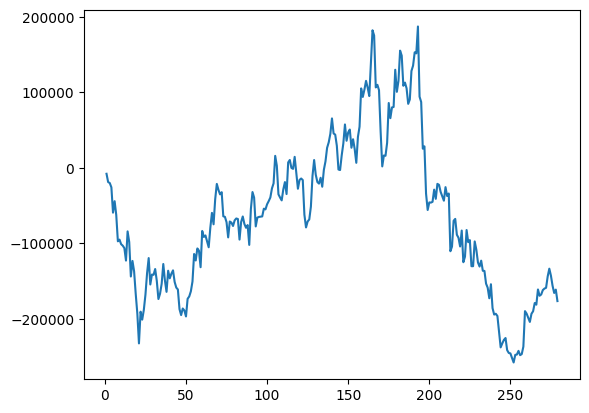

In [118]:
plt.plot(best_xgb_fit_list['perc_ret']*1000000);

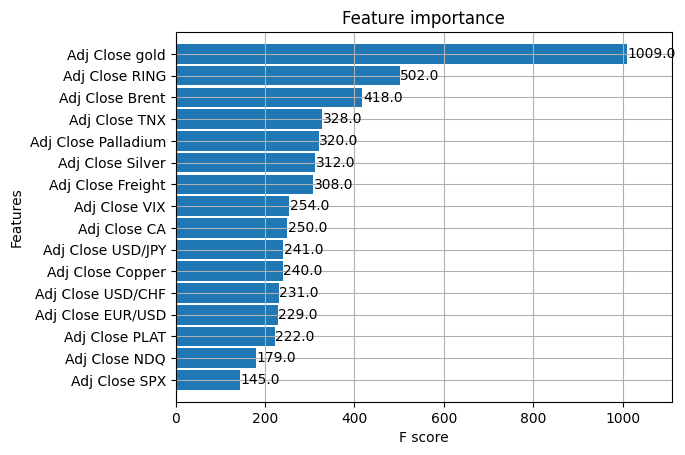

In [119]:
_ = plot_importance(best_xgb_fit, height=0.9)

# adding extra features

In [120]:
data_gold = yf.download("GC=F", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [121]:
data_gold_extra = yf.download("GC=F", start="2011-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [122]:
#pull in DXY data 
data_dxy = yf.download("DX-Y.NYB", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [123]:
#pull in Junk bond data 
data_jnk = yf.download("JNK", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [124]:
#pull in 5 year tips bond data ETF 
data_TDTF = yf.download("TDTF", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [125]:
#pull in Hang Seng Index
data_HSI = yf.download("^HSI", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [126]:
#pull in 13 weeks t-bill yield
data_IRX = yf.download("^IRX", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


In [127]:
#pull in 10 year yield
data_TNX = yf.download("^TNX", start="2012-02-03", end="2023-03-03")

[*********************100%***********************]  1 of 1 completed


adding DXY

In [128]:
#take just the close price of DXY
data_dxy_close = data_dxy['Adj Close']

In [129]:
df_new_feat = pd.merge(df, data_dxy_close, left_index=True, right_index=True, how= 'outer')

In [130]:
#rename appropriately 
df_new_feat = df_new_feat.rename(columns={'Adj Close': 'Adj Close DXY'})

adding junk bond yields

In [131]:
#take just the close price of JNK
data_jnk_close = data_jnk['Adj Close']

In [132]:
df_new_feat = pd.merge(df_new_feat, data_jnk_close, left_index=True, right_index=True, how= 'outer')

In [133]:
#rename appropriately 
df_new_feat = df_new_feat.rename(columns={'Adj Close': 'Adj Close JNK'})

adding 5 year TIPS

In [134]:
#take just the close price of TDTF
data_TDTF = data_TDTF['Adj Close']

In [135]:
df_new_feat = pd.merge(df_new_feat, data_TDTF, left_index=True, right_index=True, how= 'outer')

In [136]:
#rename appropriately 
df_new_feat = df_new_feat.rename(columns={'Adj Close': 'Adj Close TDTF'})

adding HSI index

In [137]:
#take just the close price of HSI
data_HSI = data_HSI['Adj Close']

In [138]:
df_new_feat = pd.merge(df_new_feat, data_HSI, left_index=True, right_index=True, how= 'outer')

In [139]:
#rename appropriately 
df_new_feat = df_new_feat.rename(columns={'Adj Close': 'Adj Close HSI'})

adding 13 week t-bill yield

In [140]:
#take just the close price of IRX
data_IRX = data_IRX['Adj Close']

In [141]:
df_new_feat = pd.merge(df_new_feat, data_IRX, left_index=True, right_index=True, how= 'outer')

In [142]:
#rename appropriately 
df_new_feat = df_new_feat.rename(columns={'Adj Close': 'Adj Close IRX'})

create a yield curve inversion feature

In [143]:
yield_inversion = data_TNX['Adj Close'] - data_IRX

In [144]:
df_new_feat = pd.merge(df_new_feat, yield_inversion, left_index=True, right_index=True, how= 'outer')

In [145]:
#rename appropriately 
df_new_feat = df_new_feat.rename(columns={'Adj Close': 'yield_inversion'})

adding other gold features - volume, low etc

In [146]:
data_gold_low = data_gold['Low']
data_gold_high = data_gold['High']
data_gold_volume = data_gold['Volume']

In [147]:
df_new_feat = pd.merge(df_new_feat, data_gold_low, left_index=True, right_index=True, how= 'outer')

In [148]:
df_new_feat = pd.merge(df_new_feat, data_gold_high, left_index=True, right_index=True, how= 'outer')

In [149]:
df_new_feat = pd.merge(df_new_feat, data_gold_volume, left_index=True, right_index=True, how= 'outer')

In [150]:
df_new_feat = df_new_feat.interpolate()

create bollinger bands

In [151]:
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [152]:
# Bollinger Bands
indicator_bb = BollingerBands(data_gold_extra['Adj Close'])
bb = data_gold_extra
bb['bb_h'] = indicator_bb.bollinger_hband()
bb['bb_l'] = indicator_bb.bollinger_lband()
bb = bb[['Close','bb_h','bb_l']]

In [153]:
bb_h = bb['bb_h']
bb_l = bb['bb_l']

In [154]:
df_new_feat = pd.merge(df_new_feat, bb_h, left_index=True, right_index=True, how= 'outer')

In [155]:
df_new_feat = pd.merge(df_new_feat, bb_l, left_index=True, right_index=True, how= 'outer')

create moving average divergance

In [156]:
# Moving Average Convergence Divergence
macd = MACD(data_gold_extra['Adj Close']).macd()

In [157]:
df_new_feat = pd.merge(df_new_feat, macd, left_index=True, right_index=True, how= 'outer')

create resistence strength indicatior (RSI)

In [158]:
# Resistence Strength Indicator
rsi = RSIIndicator(data_gold_extra['Adj Close']).rsi()

In [159]:
df_new_feat = pd.merge(df_new_feat, rsi, left_index=True, right_index=True, how= 'outer')

In [160]:
df_new_feat = df_new_feat[252:]

In [161]:
df_new_feat = df_new_feat.interpolate()

# model with extra features

In [162]:
df_new_feat.columns

Index(['Adj Close gold', 'Adj Close RING', 'Adj Close Brent',
       'Adj Close Silver', 'Adj Close Palladium', 'Adj Close Freight',
       'Adj Close CA', 'Adj Close TNX', 'Adj Close VIX', 'Adj Close PLAT',
       'Adj Close Copper', 'Adj Close SPX', 'Adj Close NDQ',
       'Adj Close EUR/USD', 'Adj Close USD/JPY', 'Adj Close USD/CHF',
       'Adj Close DXY', 'Adj Close JNK', 'Adj Close TDTF', 'Adj Close HSI',
       'Adj Close IRX', 'yield_inversion', 'Low', 'High', 'Volume', 'bb_h',
       'bb_l', 'MACD_12_26', 'rsi'],
      dtype='object')

In [163]:
feature_columns = ['Adj Close gold', 'Adj Close RING', 'Adj Close Brent',
       'Adj Close Silver', 'Adj Close Palladium', 'Adj Close Freight',
       'Adj Close CA', 'Adj Close TNX', 'Adj Close VIX', 'Adj Close PLAT',
       'Adj Close Copper', 'Adj Close SPX', 'Adj Close NDQ',
       'Adj Close EUR/USD', 'Adj Close USD/JPY', 'Adj Close USD/CHF', 'Adj Close DXY', 'Adj Close JNK', 'Adj Close TDTF',
       'Adj Close HSI', 'Adj Close IRX', 'yield_inversion', 'Low', 'High',
       'Volume', 'bb_h', 'bb_l', 'MACD_12_26', 'rsi']

In [164]:
#preprocessing / scaling the data of the train set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data_train = scaler.fit_transform(df_new_feat[feature_columns][:-280])
feature_minmax_transform_train = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data_train, index=df_new_feat[:-280].index)
feature_minmax_transform_train

,Adj Close gold,Adj Close RING,Adj Close Brent,Adj Close Silver,Adj Close Palladium,Adj Close Freight,Adj Close CA,Adj Close TNX,Adj Close VIX,Adj Close PLAT,...,Adj Close HSI,Adj Close IRX,yield_inversion,Low,High,Volume,bb_h,bb_l,MACD_12_26,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-03,0.686619,0.958316,0.914349,0.865578,0.094832,0.714066,0.127970,0.530165,0.108226,0.906014,...,0.171786,0.069638,0.684410,0.682532,0.698601,0.001406,0.691988,0.629334,0.705717,0.674011
2012-02-06,0.671530,0.952985,0.908072,0.865460,0.093679,0.714566,0.126319,0.512614,0.117199,0.904173,...,0.168644,0.067648,0.671902,0.671262,0.675624,0.001879,0.694104,0.639127,0.693367,0.604576
2012-02-07,0.695113,0.962679,0.918197,0.882897,0.094951,0.710063,0.121812,0.536380,0.115704,0.926091,...,0.167926,0.073617,0.686446,0.671161,0.685315,0.000704,0.697115,0.651582,0.697032,0.669122
2012-02-08,0.678025,0.951046,0.920221,0.863531,0.097635,0.715067,0.122628,0.539671,0.122638,0.937752,...,0.189255,0.071628,0.690518,0.686255,0.688811,0.002472,0.698489,0.661260,0.685641,0.595359
2012-02-09,0.687719,0.952985,0.927848,0.871836,0.095806,0.713065,0.120436,0.565996,0.129028,0.937314,...,0.188691,0.075607,0.708551,0.684142,0.687013,0.000308,0.700723,0.670129,0.680733,0.622702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.743679,0.430083,0.848947,0.419602,0.747088,0.122349,0.936414,0.469104,0.213324,0.371120,...,0.375232,0.110625,0.605875,0.743510,0.735764,0.004491,0.773688,0.847128,0.471699,0.395033
2022-02-01,0.748976,0.437914,0.849285,0.427514,0.744703,0.131767,0.957438,0.475686,0.174303,0.373400,...,0.388109,0.122563,0.602385,0.755585,0.743357,0.000577,0.773656,0.847268,0.461377,0.418257
2022-02-02,0.757869,0.441425,0.849690,0.432041,0.753846,0.138394,0.961471,0.463254,0.176071,0.391373,...,0.400987,0.115400,0.597731,0.753572,0.747353,0.004374,0.773537,0.846855,0.459321,0.456901


In [165]:
#shifting the gold close by a day so that we try and predict
target_train = feature_minmax_transform_train['Adj Close gold'].shift(-1)

In [166]:
#cutting the target for the train
y_train = target_train[:-1]

In [167]:
#cutting the train set
X_train = feature_minmax_transform_train[:-1]

In [168]:
params = {
    #'eval_metric': 'rmse',
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [25, 50, 100, 200, 300, 400, 500]
}

cv = TimeSeriesSplit(n_splits=3)

model = XGBRegressor()
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=50, n_jobs=-1, cv=cv, verbose=3)

In [169]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [25, 50, 100, 200, 300,
                                                         400, 500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   verbose=3)

In [170]:
#apply the same scalar to the test set so there's no data leakage
feature_minmax_transform_test = scaler.transform(df_new_feat[feature_columns][-281:])
feature_minmax_transform_test = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_test, index=df_new_feat[-281:].index)
feature_minmax_transform_test

,Adj Close gold,Adj Close RING,Adj Close Brent,Adj Close Silver,Adj Close Palladium,Adj Close Freight,Adj Close CA,Adj Close TNX,Adj Close VIX,Adj Close PLAT,...,Adj Close HSI,Adj Close IRX,yield_inversion,Low,High,Volume,bb_h,bb_l,MACD_12_26,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-04,0.755271,0.431163,0.877025,0.422751,0.722520,0.140836,0.952884,0.523218,0.191434,0.374277,...,0.426742,0.130521,0.634380,0.750956,0.750949,0.001478,0.771900,0.848297,0.451537,0.448065
2022-02-07,0.769261,0.448446,0.870343,0.446408,0.710356,0.148859,0.949431,0.518099,0.186540,0.370857,...,0.427160,0.122563,0.636126,0.767659,0.758542,0.001556,0.772066,0.850807,0.459566,0.510715
2022-02-08,0.775257,0.457358,0.857114,0.451092,0.711986,0.154440,0.962875,0.531993,0.167233,0.385148,...,0.410454,0.151214,0.626236,0.773596,0.764835,0.000280,0.772605,0.853417,0.469944,0.536102
2022-02-09,0.783851,0.460598,0.859139,0.456642,0.720215,0.161765,0.984412,0.522852,0.147111,0.385850,...,0.443891,0.149224,0.620419,0.783961,0.772428,0.001768,0.774137,0.853570,0.483804,0.571664
2022-02-10,0.784851,0.438724,0.860624,0.463846,0.712344,0.166997,0.977533,0.560146,0.200816,0.390321,...,0.450195,0.189017,0.621001,0.779433,0.779321,0.000945,0.775164,0.853430,0.495088,0.575838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,0.765664,0.327278,0.764781,0.351702,0.373922,0.185996,0.856888,1.251554,0.160571,0.303086,...,0.117441,1.898130,-0.078243,0.767458,0.754745,0.002146,0.852196,0.860869,0.321137,0.244677
2023-02-28,0.777556,0.335004,0.774028,0.363157,0.371497,0.192588,0.853197,1.249360,0.157172,0.315010,...,0.106914,1.916037,-0.093077,0.766653,0.767233,0.001600,0.843045,0.860544,0.325188,0.328605
2023-03-01,0.786349,0.345214,0.778348,0.363078,0.378374,0.192808,0.856860,1.277879,0.155540,0.320533,...,0.162616,1.922006,-0.074753,0.785772,0.778921,0.000546,0.830117,0.864774,0.335876,0.385281


In [171]:
#shifting the gold close by a day so that we try and predict
target_test = feature_minmax_transform_test['Adj Close gold'].shift(-1)

In [172]:
#cutting to leave the target test set
y_test = target_test[-281:-1]

In [173]:
#cutting to just leave the test set
X_test = feature_minmax_transform_test[-281:-1]

In [174]:
# Print the best hyperparameters
print(random_search.best_params_)

# Make predictions on the test set using the best model
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print('RMSE:', rmse)
print('R2 score:', r2)

{'subsample': 0.7, 'n_estimators': 25, 'max_depth': 3, 'learning_rate': 0.25, 'colsample_bytree': 1.0}
RMSE: 0.024918168767462067
R2 score: 0.9295312414958634


In [175]:
best_xgb_fit = best_xgb.fit(X_train, y_train)

RMSE:  0.024918168767462067
R2 score:  0.9295312414958634


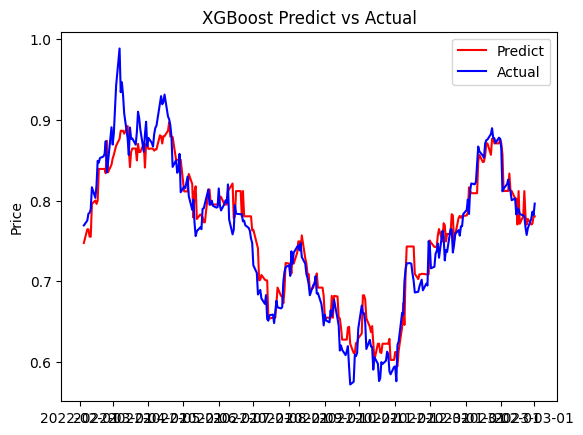

In [176]:
validate_result(best_xgb_fit,'XGBoost')

In [177]:
best_xgb_fit_list = best_xgb_fit.predict(X_test)

In [178]:
best_xgb_fit_list = best_xgb_fit_list.tolist()

In [179]:
predict_real = []
for i in best_xgb_fit_list:
    predict_real.append((((max_gold - min_gold)*i)+min_gold))

In [180]:
best_xgb_fit_list = pd.DataFrame(predict_real,columns=['predict'])

In [181]:
actual = []
for i in y_test:
    actual.append(i)

In [182]:
actual_real = []
for i in actual:
    actual_real.append((((max_gold - min_gold)*i)+min_gold))

In [183]:
best_xgb_fit_list['actual'] = actual_real

In [184]:
best_xgb_fit_list['actual_1'] = best_xgb_fit_list['actual'].shift(1)

In [185]:
best_xgb_fit_list['pred_change'] = best_xgb_fit_list['predict'] - best_xgb_fit_list['actual_1']

In [186]:
#create a signal column for the prediction
signal = []
for index, row in best_xgb_fit_list.iterrows():
    if row['pred_change'] > 0:
        signal.append(1)
    else:
        signal.append(-1)

In [187]:
best_xgb_fit_list['signal'] = signal

In [188]:
best_xgb_fit_list['perc_change'] = (best_xgb_fit_list['actual'] - best_xgb_fit_list['actual_1']) / best_xgb_fit_list['actual_1']

In [189]:
best_xgb_fit_list['PnL_change'] = best_xgb_fit_list['signal'] * best_xgb_fit_list['perc_change']

In [190]:
best_xgb_fit_list = best_xgb_fit_list.tail(-1)

In [191]:
best_xgb_fit_list['perc_ret'] = (1 + best_xgb_fit_list.PnL_change).cumprod() - 1

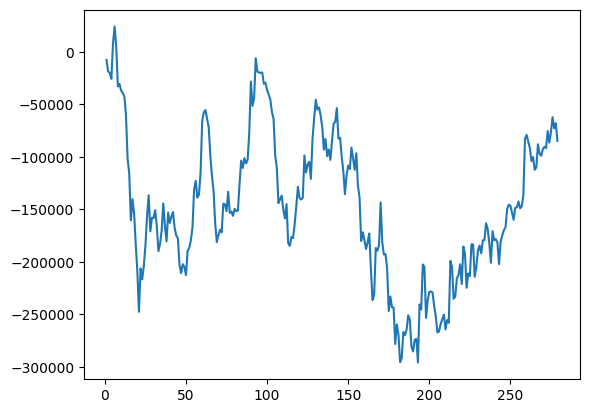

In [192]:
plt.plot(best_xgb_fit_list['perc_ret']*1000000);

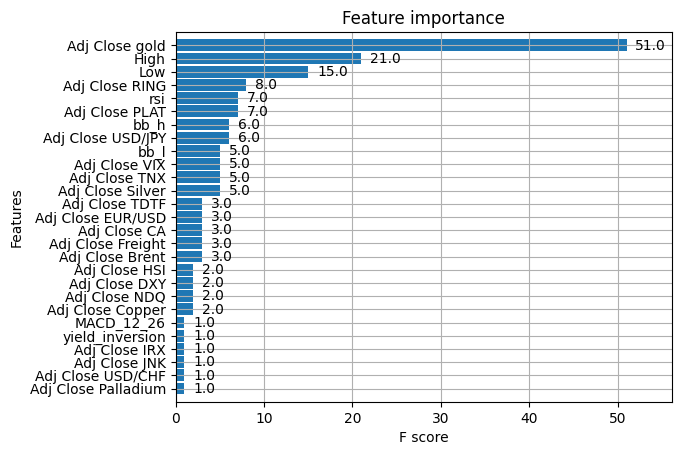

In [193]:
_ = plot_importance(best_xgb_fit, height=0.9)

# refining the feature

In [194]:
feature_columns = ['Adj Close gold', 'Adj Close RING', 'Adj Close Brent',
       'Adj Close Silver', 'Adj Close Palladium', 'Adj Close Freight',
       'Adj Close CA', 'Adj Close TNX', 'Adj Close VIX', 'Adj Close PLAT',
       'Adj Close Copper', 'Adj Close SPX', 'Adj Close NDQ','Adj Close DXY', 'Adj Close JNK', 'Adj Close TDTF',
       'Adj Close HSI', 'yield_inversion', 'Low', 'High',
       'Volume', 'bb_h', 'bb_l', 'MACD_12_26', 'rsi']

In [195]:
#preprocessing / scaling the data of the train set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data_train = scaler.fit_transform(df_new_feat[feature_columns][:-280])
feature_minmax_transform_train = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data_train, index=df_new_feat[:-280].index)
feature_minmax_transform_train

,Adj Close gold,Adj Close RING,Adj Close Brent,Adj Close Silver,Adj Close Palladium,Adj Close Freight,Adj Close CA,Adj Close TNX,Adj Close VIX,Adj Close PLAT,...,Adj Close HSI,Adj Close IRX,yield_inversion,Low,High,Volume,bb_h,bb_l,MACD_12_26,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-03,0.686619,0.958316,0.914349,0.865578,0.094832,0.714066,0.127970,0.530165,0.108226,0.906014,...,0.171786,0.069638,0.684410,0.682532,0.698601,0.001406,0.691988,0.629334,0.705717,0.674011
2012-02-06,0.671530,0.952985,0.908072,0.865460,0.093679,0.714566,0.126319,0.512614,0.117199,0.904173,...,0.168644,0.067648,0.671902,0.671262,0.675624,0.001879,0.694104,0.639127,0.693367,0.604576
2012-02-07,0.695113,0.962679,0.918197,0.882897,0.094951,0.710063,0.121812,0.536380,0.115704,0.926091,...,0.167926,0.073617,0.686446,0.671161,0.685315,0.000704,0.697115,0.651582,0.697032,0.669122
2012-02-08,0.678025,0.951046,0.920221,0.863531,0.097635,0.715067,0.122628,0.539671,0.122638,0.937752,...,0.189255,0.071628,0.690518,0.686255,0.688811,0.002472,0.698489,0.661260,0.685641,0.595359
2012-02-09,0.687719,0.952985,0.927848,0.871836,0.095806,0.713065,0.120436,0.565996,0.129028,0.937314,...,0.188691,0.075607,0.708551,0.684142,0.687013,0.000308,0.700723,0.670129,0.680733,0.622702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.743679,0.430083,0.848947,0.419602,0.747088,0.122349,0.936414,0.469104,0.213324,0.371120,...,0.375232,0.110625,0.605875,0.743510,0.735764,0.004491,0.773688,0.847128,0.471699,0.395033
2022-02-01,0.748976,0.437914,0.849285,0.427514,0.744703,0.131767,0.957438,0.475686,0.174303,0.373400,...,0.388109,0.122563,0.602385,0.755585,0.743357,0.000577,0.773656,0.847268,0.461377,0.418257
2022-02-02,0.757869,0.441425,0.849690,0.432041,0.753846,0.138394,0.961471,0.463254,0.176071,0.391373,...,0.400987,0.115400,0.597731,0.753572,0.747353,0.004374,0.773537,0.846855,0.459321,0.456901


In [196]:
#shifting the gold close by a day so that we try and predict
target_train = feature_minmax_transform_train['Adj Close gold'].shift(-1)

In [197]:
#cutting the target for the train
y_train = target_train[:-1]

In [198]:
#cutting the train set
X_train = feature_minmax_transform_train[:-1]

In [199]:
params = {
    #'eval_metric': 'rmse',
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [25, 50, 100, 200, 300, 400, 500]
}

cv = TimeSeriesSplit(n_splits=3)

model = XGBRegressor()
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=50, n_jobs=-1, cv=cv, verbose=3)

In [200]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [25, 50, 100, 200, 300,
                                                         400, 500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   verbose=3)

In [201]:
#apply the same scalar to the test set so there's no data leakage
feature_minmax_transform_test = scaler.transform(df_new_feat[feature_columns][-281:])
feature_minmax_transform_test = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_test, index=df_new_feat[-281:].index)
feature_minmax_transform_test

,Adj Close gold,Adj Close RING,Adj Close Brent,Adj Close Silver,Adj Close Palladium,Adj Close Freight,Adj Close CA,Adj Close TNX,Adj Close VIX,Adj Close PLAT,...,Adj Close HSI,Adj Close IRX,yield_inversion,Low,High,Volume,bb_h,bb_l,MACD_12_26,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-04,0.755271,0.431163,0.877025,0.422751,0.722520,0.140836,0.952884,0.523218,0.191434,0.374277,...,0.426742,0.130521,0.634380,0.750956,0.750949,0.001478,0.771900,0.848297,0.451537,0.448065
2022-02-07,0.769261,0.448446,0.870343,0.446408,0.710356,0.148859,0.949431,0.518099,0.186540,0.370857,...,0.427160,0.122563,0.636126,0.767659,0.758542,0.001556,0.772066,0.850807,0.459566,0.510715
2022-02-08,0.775257,0.457358,0.857114,0.451092,0.711986,0.154440,0.962875,0.531993,0.167233,0.385148,...,0.410454,0.151214,0.626236,0.773596,0.764835,0.000280,0.772605,0.853417,0.469944,0.536102
2022-02-09,0.783851,0.460598,0.859139,0.456642,0.720215,0.161765,0.984412,0.522852,0.147111,0.385850,...,0.443891,0.149224,0.620419,0.783961,0.772428,0.001768,0.774137,0.853570,0.483804,0.571664
2022-02-10,0.784851,0.438724,0.860624,0.463846,0.712344,0.166997,0.977533,0.560146,0.200816,0.390321,...,0.450195,0.189017,0.621001,0.779433,0.779321,0.000945,0.775164,0.853430,0.495088,0.575838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,0.765664,0.327278,0.764781,0.351702,0.373922,0.185996,0.856888,1.251554,0.160571,0.303086,...,0.117441,1.898130,-0.078243,0.767458,0.754745,0.002146,0.852196,0.860869,0.321137,0.244677
2023-02-28,0.777556,0.335004,0.774028,0.363157,0.371497,0.192588,0.853197,1.249360,0.157172,0.315010,...,0.106914,1.916037,-0.093077,0.766653,0.767233,0.001600,0.843045,0.860544,0.325188,0.328605
2023-03-01,0.786349,0.345214,0.778348,0.363078,0.378374,0.192808,0.856860,1.277879,0.155540,0.320533,...,0.162616,1.922006,-0.074753,0.785772,0.778921,0.000546,0.830117,0.864774,0.335876,0.385281


In [202]:
#shifting the gold close by a day so that we try and predict
target_test = feature_minmax_transform_test['Adj Close gold'].shift(-1)

In [203]:
#cutting to leave the target test set
y_test = target_test[-281:-1]

In [204]:
#cutting to just leave the test set
X_test = feature_minmax_transform_test[-281:-1]

In [205]:
# Print the best hyperparameters
print(random_search.best_params_)

# Make predictions on the test set using the best model
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print('RMSE:', rmse)
print('R2 score:', r2)

{'subsample': 0.8, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.25, 'colsample_bytree': 1.0}
RMSE: 0.026903010013586706
R2 score: 0.917857839584379


In [206]:
best_xgb_fit = best_xgb.fit(X_train, y_train)

RMSE:  0.026903010013586706
R2 score:  0.917857839584379


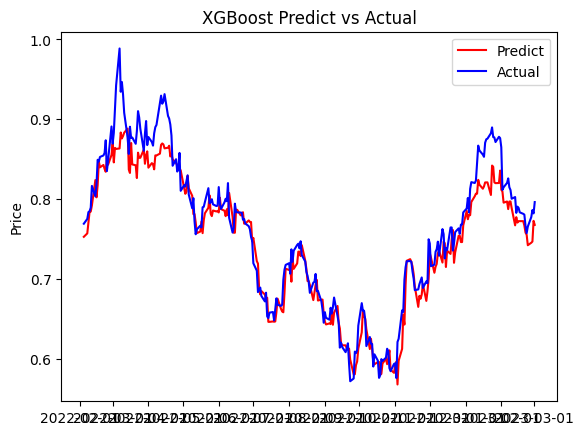

In [207]:
validate_result(best_xgb_fit,'XGBoost')

In [208]:
best_xgb_fit_list = best_xgb_fit.predict(X_test)

In [209]:
best_xgb_fit_list = best_xgb_fit_list.tolist()

In [210]:
predict_real = []
for i in best_xgb_fit_list:
    predict_real.append((((max_gold - min_gold)*i)+min_gold))

In [211]:
best_xgb_fit_list = pd.DataFrame(predict_real,columns=['predict'])

In [212]:
actual = []
for i in y_test:
    actual.append(i)

In [213]:
actual_real = []
for i in actual:
    actual_real.append((((max_gold - min_gold)*i)+min_gold))

In [214]:
best_xgb_fit_list['actual'] = actual_real

In [215]:
best_xgb_fit_list['actual_1'] = best_xgb_fit_list['actual'].shift(1)

In [216]:
best_xgb_fit_list['pred_change'] = best_xgb_fit_list['predict'] - best_xgb_fit_list['actual_1']

In [217]:
#create a signal column for the prediction
signal = []
for index, row in best_xgb_fit_list.iterrows():
    if row['pred_change'] > 0:
        signal.append(1)
    else:
        signal.append(-1)

In [218]:
best_xgb_fit_list['signal'] = signal

In [219]:
best_xgb_fit_list['perc_change'] = (best_xgb_fit_list['actual'] - best_xgb_fit_list['actual_1']) / best_xgb_fit_list['actual_1']

In [220]:
best_xgb_fit_list['PnL_change'] = best_xgb_fit_list['signal'] * best_xgb_fit_list['perc_change']

In [221]:
best_xgb_fit_list = best_xgb_fit_list.tail(-1)

In [222]:
best_xgb_fit_list['perc_ret'] = (1 + best_xgb_fit_list.PnL_change).cumprod() - 1

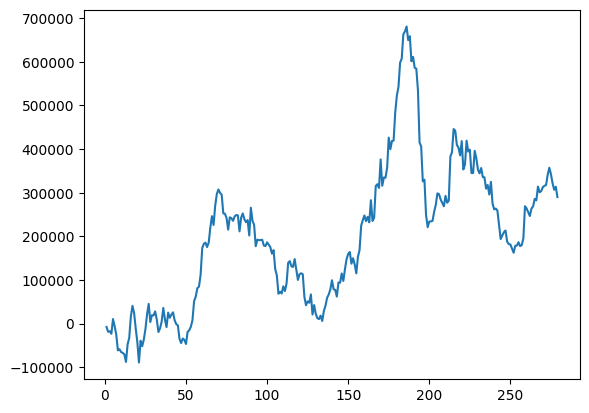

In [223]:
plt.plot(best_xgb_fit_list['perc_ret']*1000000);

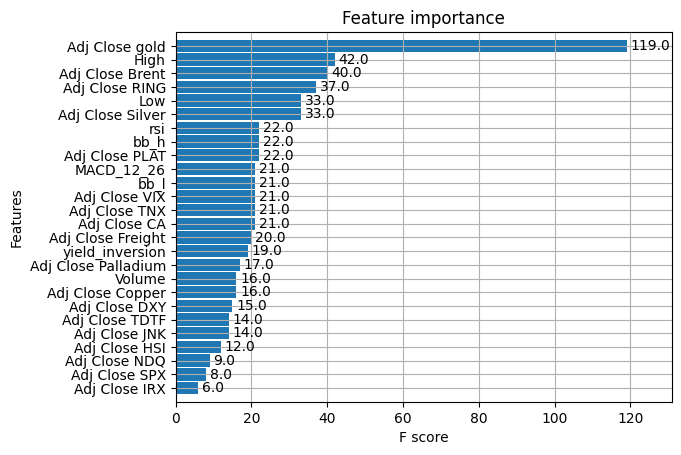

[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8;, score=0.782 total time=   0.2s
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.05, max_depth=4, n_estimators=25, subsample=1.0;, score=-2.872 total time=   0.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.05, max_depth=4, n_estimators=25, subsample=1.0;, score=-1.110 total time=   0.1s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.05, max_depth=4, n_estimators=25, subsample=1.0;, score=-0.032 total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-4.416 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-2.179 total time=   0.3s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, n_estimators=400, subsample=0.9;, score=-0.255 total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=25, subsample=0.6;, score=-1.152 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, n_estimators=25, subsample=0.7;, score=0.481 total time=   0.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9;, score=-0.121 total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.9;, score=-0.173 total time=   0.7s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.25, max_depth=7, n_estimators=300, subsample=0.6;, score=-0.430 total time=   1.3s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=25, subsample=0.9;, score=-0.401 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.15, max_depth=3, n_estimators=25, subsample=0.7;, score=0.314 total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=25, subsample=0.6;, score=-15.017 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, n_estimators=25, subsample=0.7;, score=-0.161 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, n_estimators=25, subsample=0.7;, score=-0.623 total time=   0.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9;, score=-0.403 total time=   0.6s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.6;, score=-0.809 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.25, max_depth=7, n_estimators=300, subsample=0.6;, score=-0.161 total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8;, score=-0.577 total time=   1.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.15, max_depth=3,

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.8;, score=-0.504 total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.9;, score=-1.179 total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.6;, score=-9.802 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.6;, score=-8.486 total time=   0.1s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, n_estimators=400, subsample=0.9;, score=-0.271 total time=   0.8s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1.0;, score=0.918 total time=   0.6s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=2, n_estimators=25, subsample=0.9;, score=-0.676 total time=   0.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=2, n_e

In [224]:
_ = plot_importance(best_xgb_fit, height=0.9)

In [225]:
import os

In [226]:
os

<module 'os' from '/Users/sambrook/.pyenv/versions/3.10.6/lib/python3.10/os.py'>